In [1]:
import pandas as pd
import FINE as fn

%load_ext autoreload
%autoreload 2

In [38]:
def dsm_test_esM():
    """
    Generate a simple energy system model with one node, two fixed generators and one load time series for testing
    demand side management functionality.
    """
    # load without dsm
    now = pd.Timestamp.now().round('h')
    number_of_time_steps = 24+8
    #t_index = pd.date_range(now, now + pd.DateOffset(hours=number_of_timeSteps - 1), freq='h')
    t_index = range(number_of_time_steps)
    load_without_dsm = pd.Series([80.] * number_of_time_steps, index=t_index)

    timestep_up = 10
    timestep_down = 20
    load_without_dsm[timestep_up:timestep_down] += 40.

    time_shift = 3
    cheap_capacity = 100.
    expensive_capacity = 20.

    # set up energy model
    esM = fn.EnergySystemModel(locations={'location'},
                               commodities={'electricity'},
                               numberOfTimeSteps=number_of_time_steps,
                               commodityUnitsDict={'electricity': r'MW$_{el}$'},
                               hoursPerTimeStep=1, costUnit='1 Euro',
                               lengthUnit='km',
                               verboseLogLevel=0)
    esM.add(fn.Source(esM=esM, name='cheap', commodity='electricity', hasCapacityVariable=False,
                      operationRateMax=pd.Series(cheap_capacity, index=t_index), opexPerOperation=25))
    esM.add(fn.Source(esM=esM, name='expensive', commodity='electricity', hasCapacityVariable=False,
                      operationRateMax=pd.Series(expensive_capacity, index=t_index), opexPerOperation=50))
    esM.add(fn.Source(esM=esM, name='back-up', commodity='electricity', hasCapacityVariable=False,
                      operationRateMax=pd.Series(1000, index=t_index), opexPerOperation=1000))

    return esM, load_without_dsm, timestep_up, timestep_down, time_shift, cheap_capacity


In [39]:
dsm_test_esM_ = dsm_test_esM()

In [40]:
"""
Given a one-node system with two generators, check whether the load and generation is shifted correctly in both
directions with and without demand side management.
"""

esM_without, load_without_dsm, timestep_up, timestep_down, time_shift, cheap_capacity = dsm_test_esM_

esM_without.add(fn.Sink(esM=esM_without, name='load', commodity='electricity',
                        hasCapacityVariable=False, operationRateFix=load_without_dsm))

esM_without.optimize(timeSeriesAggregation=False, solver='glpk')  # without dsm

generator_outputs = esM_without.componentModelingDict['SourceSinkModel'].operationVariablesOptimum

# benchmark generation without dsm
cheap_without_dsm = load_without_dsm.clip(0, cheap_capacity).copy()
cheap_without_dsm.name = ('cheap', 'location')
expensive_without_dsm = load_without_dsm - cheap_without_dsm
expensive_without_dsm.name = ('expensive', 'location')

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0100 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.0000 sec)

Declaring objective function...
		(0.0000 sec)

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmp94elfdi5.glpk.raw --wglp
 C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmp_lp8dvca.glpk.glp --cpxlp C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmpnti2k092.pyomo.lp
Reading problem data from 'C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmpnti2k092.pyomo.lp'...
161 rows, 129 columns, 257 non-zeros
972 lines were read
Writing problem data to 'C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmp_lp8dvca.glpk.glp'...
775 lines were written
GLPK Simplex Optimizer, v4.65
161 rows, 129 columns, 257 non-zeros
Preprocessing...
22 rows, 44 columns, 44 non-zeros
Scaling...
 A: min|aij| =  1.00

In [41]:
print((generator_outputs.loc[('cheap', 'location')] == cheap_without_dsm).all())
print((generator_outputs.loc[('expensive', 'location')] == expensive_without_dsm).all())

True
True


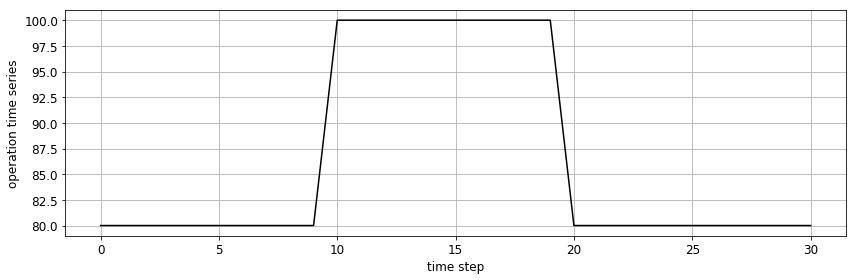

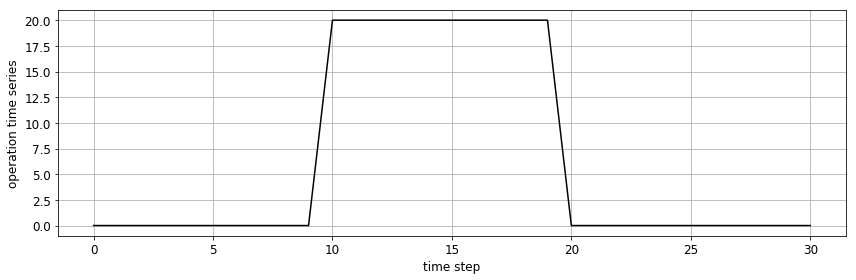

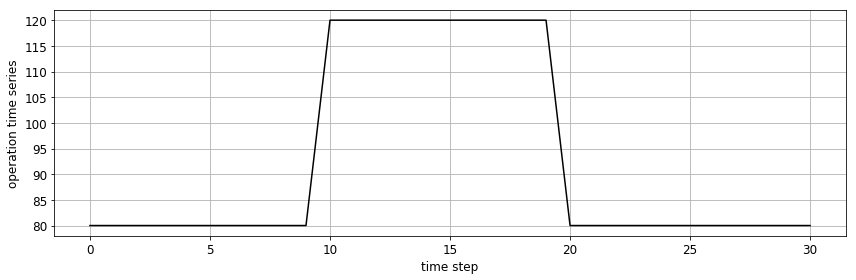

In [42]:
fig, ax = fn.plotOperation(esM_without,'cheap','location')
fig, ax = fn.plotOperation(esM_without,'expensive','location')
fig, ax = fn.plotOperation(esM_without,'load','location')

In [43]:
dsm_test_esM_ = dsm_test_esM()

In [44]:
# add DSM
esM_with = dsm_test_esM_[0]

esM_with.add(fn.DemandSideManagement(esM=esM_with, name='flexible demand', commodity='electricity',
                                     hasCapacityVariable=False, tUp=time_shift, tDown=time_shift,
                                     operationRateFix=load_without_dsm))
esM_with.optimize(timeSeriesAggregation=False, solver='glpk')  # with dsm

generator_outputs = esM_with.componentModelingDict["SourceSinkModel"].operationVariablesOptimum
esM_load_with_DSM = esM_with.componentModelingDict['DSMModel'].operationVariablesOptimum

# benchmark generation and load with dsm
expensive_with_dsm = expensive_without_dsm.copy()
expensive_with_dsm[timestep_up:timestep_up + time_shift] -= 10
expensive_with_dsm[timestep_down - time_shift:timestep_down] -= 10
expensive_with_dsm.name = ('expensive', 'location')

cheap_with_dsm = cheap_without_dsm.copy()
cheap_with_dsm[timestep_up - time_shift:timestep_up] += 10
cheap_with_dsm[timestep_down:timestep_down + time_shift] += 10
cheap_with_dsm.name = ('cheap', 'location')

load_with_dsm = load_without_dsm.copy()
load_with_dsm[timestep_up - time_shift:timestep_up] += 10
load_with_dsm[timestep_up:timestep_up + time_shift] -= 10
load_with_dsm[timestep_down - time_shift:timestep_down] -= 10
load_with_dsm[timestep_down:timestep_down + time_shift] += 10
load_with_dsm.name = ('flexible demand', 'location')

tUp+tDown+1 is not a divisor of the total number of time steps of the energy system. This shortens the shiftable timeframe of demand_0 by 3 time steps
tUp+tDown+1 is not a divisor of the total number of time steps of the energy system. This shortens the shiftable timeframe of demand_1 by 3 time steps
tUp+tDown+1 is not a divisor of the total number of time steps of the energy system. This shortens the shiftable timeframe of demand_2 by 3 time steps
tUp+tDown+1 is not a divisor of the total number of time steps of the energy system. This shortens the shiftable timeframe of demand_3 by 3 time steps
Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0100 sec)

Declaring sets, variables and constraints for StorageExtModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0400 sec)

Declaring sets, variables and constraints for DSMModel
	declaring sets... 
	declaring variables.

e:\models\fine_gitlab\fine\FINE\subclasses\storageExt.py:73: UserWarning: Warning only relevant when time series aggregation is used in optimization:
Setting the stateOfChargeOpRateMax parameter might lead to unwanted modeling behavior
and should be handled with caution.
  + 'and should be handled with caution.')
e:\models\fine_gitlab\fine\FINE\subclasses\storageExt.py:73: UserWarning: Warning only relevant when time series aggregation is used in optimization:
Setting the stateOfChargeOpRateMax parameter might lead to unwanted modeling behavior
and should be handled with caution.
  + 'and should be handled with caution.')
e:\models\fine_gitlab\fine\FINE\subclasses\storageExt.py:73: UserWarning: Warning only relevant when time series aggregation is used in optimization:
Setting the stateOfChargeOpRateMax parameter might lead to unwanted modeling behavior
and should be handled with caution.
  + 'and should be handled with caution.')
e:\models\fine_gitlab\fine\FINE\subclasses\storageExt.p

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmp60z9ez3o.glpk.raw --wglp
 C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmpm80r2rzg.glpk.glp --cpxlp C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmpx0vczz3y.pyomo.lp
Reading problem data from 'C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmpx0vczz3y.pyomo.lp'...
1064 rows, 808 columns, 2287 non-zeros
6390 lines were read
Writing problem data to 'C:\Users\L1DDC~1.WEL\AppData\Local\Temp\tmpm80r2rzg.glpk.glp'...
4867 lines were written
GLPK Simplex Optimizer, v4.65
1064 rows, 808 columns, 2287 non-zeros
Preprocessing...
250 rows, 491 columns, 918 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 250
*     0: obj =   6.821850000e+08 inf =   0.000e+00 (59)
*    99: obj =   2.025750000e+07 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used: 

In [45]:
print((generator_outputs.loc[('cheap', 'location')] == cheap_with_dsm).all())
print((generator_outputs.loc[('expensive', 'location')] == expensive_with_dsm).all())
print((esM_load_with_DSM.loc[('flexible demand', 'location')] == load_with_dsm).all())

False
False
False


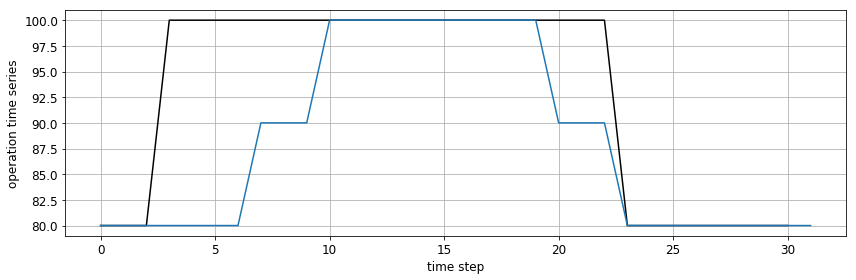

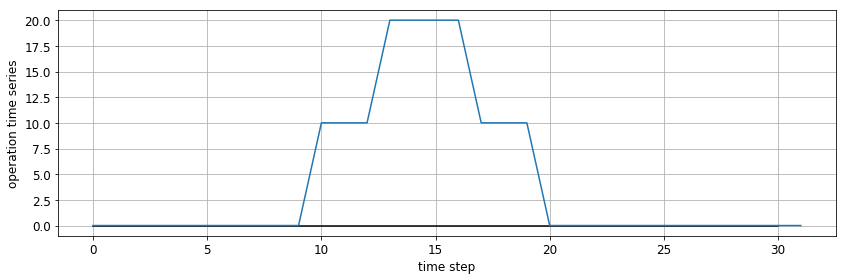

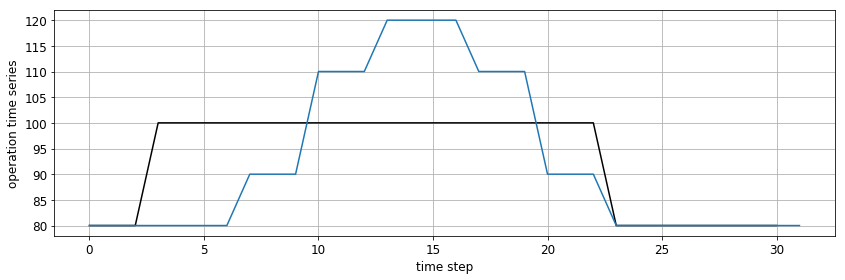

In [46]:
fig, ax = fn.plotOperation(esM_with,'cheap','location')
ax.plot(cheap_with_dsm)
fig, ax = fn.plotOperation(esM_with,'expensive','location')
ax.plot(expensive_with_dsm)
fig, ax = fn.plotOperation(esM_with,'flexible demand','location')
ax.plot(load_with_dsm)

In [47]:
esM_with.getComponent('flexible demand').operationRateFix

location
Period TimeStep          
0      0             80.0
       1             80.0
       2             80.0
       3             80.0
       4             80.0
       5             80.0
       6             80.0
       7             80.0
       8             80.0
       9             80.0
       10            80.0
       11            80.0
       12            80.0
       13           120.0
       14           120.0
       15           120.0
       16           120.0
       17           120.0
       18           120.0
       19           120.0
       20           120.0
       21           120.0
       22           120.0
       23            80.0
       24            80.0
       25            80.0
       26            80.0
       27            80.0
       28            80.0
       29            80.0
       30            80.0
       31            80.0

In [48]:
esM_with.componentModelingDict['DSMModel'].operationVariablesOptimum

,,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
flexible demand,location,80.0,80.0,80.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,100.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0


In [49]:
esM_with.componentModelingDict['StorageExtModel'].chargeOperationVariablesOptimum

,,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
flexible demand_0,location,80.0,0.0,0.0,20.0,20.0,20.0,20.0,80.0,40.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0
flexible demand_1,location,0.0,80.0,0.0,0.0,0.0,0.0,0.0,20.0,60.0,20.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0
flexible demand_2,location,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,...,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0
flexible demand_3,location,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
flexible demand_4,location,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
flexible demand_5,location,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0
flexible demand_6,location,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0


In [50]:
esM_with.componentModelingDict['StorageExtModel'].dischargeOperationVariablesOptimum

,,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
flexible demand_0,location,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0
flexible demand_1,location,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,...,120.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0
flexible demand_2,location,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,...,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0
flexible demand_3,location,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
flexible demand_4,location,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
flexible demand_5,location,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0
flexible demand_6,location,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0


In [52]:
esM_with.componentModelingDict['StorageExtModel'].stateOfChargeOperationVariablesOptimum

,,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
flexible demand_0,location,0.0,0.0,0.0,0.0,20.0,40.0,60.0,80.0,80.0,120.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
flexible demand_1,location,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
flexible demand_2,location,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
flexible demand_3,location,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
flexible demand_4,location,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
flexible demand_5,location,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
flexible demand_6,location,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
